In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_theme(style="dark")
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

# # for creating a responsive plot
# %matplotlib ipympl
# %matplotlib widget

import  torch
import torch.nn.functional as F
'''
To get same results when sampling during different runs.
If you are using cuDNN, you should set the deterministic behavior.
This might make your code quite slow, but might be a good method to check your code and deactivate it later.
'''
torch.backends.cudnn.deterministic = True

In [2]:

words = open('names.txt', 'r').read().splitlines()

In [3]:
# sets takes an input, create a set of all items,
# & doesn't allow duplicates :)
# then we want a sorted list of course, the order matters! 
chars = sorted(list(set(''.join(words))))
# a map or dict:
# start from 1
s_to_i = { s:i for i, s in enumerate(chars, start=1)}
s_to_i['.'] = 0
i_to_s = { i:s for s,i in s_to_i.items()}

In [2]:
import itertools
def plot_heatmap(tensor, text=True, nrow=None, ncol=None, fig_size=(10,10)):
    if (nrow is None) or (ncol is None):
        nrow = tensor.shape[0]
        ncol = tensor.shape[1]
    plt.figure(figsize=fig_size)
    plt.imshow(tensor.detach().numpy(), cmap= 'Blues')
    # manually write text on each cell (seaborn annot doesn't look good)
    if text:
        for i, j in itertools.product(range(nrow), range(ncol)):
            # x:col, y:rows, the origin is top left corner, makes bottom <->top
            plt.text(x=j, y=i, s=f'{tensor[i,j].item():.2f}', ha='center', va='center', color='grey')
    plt.axis('off')

### 2D & 3d Embedding Visualization

In [3]:
def plot_2d_emb(emb_lkt, nclass, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.scatter(x= emb_lkt[:,0].data, y=emb_lkt[:,1].data, s=200)
    for i in range(nclass):
        plt.text(x=emb_lkt[i,0].item(), y=emb_lkt[i,1].item(), s=i_to_s[i], ha='center', va='center', color='white')
    plt.grid('minor')

# def plot_3d_emb(emb_lkt, nclass, figsize=(8,8)):
#     tensor = emb_lkt.data.detach().numpy()
#     fig = plt.figure(figsize=figsize)
#     ax = Axes3D(fig)
#     ax.scatter(xs= tensor[:,0], ys=tensor[:,1], zs=tensor[:,2], s=200)
#     for i in range(nclass):
#         ax.text(x=tensor[i,0], y=tensor[i,1],z=tensor[i,2], s=i_to_s[i], ha='center', va='center', color='white')
#     # displaying the plot
#     plt.grid('minor')
#     plt.show()

## Splitting dataset into Training Dev & Test sets

1. split rate 80%, 10%, 10%

2. Dev or Validation set is for hyper parameter tuning

3. test should be touched at he end

In [6]:
WINDOW_SIZE = 5
NCLASS = 27

def build_dataset(words:list, type:str):
    xs, ys = [], []

    # context input window: how many characters do we take to predict the next one?
    

    for w in words:
        context_window = [0]*WINDOW_SIZE
        for ch in f'{w}.':
            idx_y = s_to_i[ch]
            ys.append(idx_y)

            xs.append(context_window) # input : ch1
            # print(''.join(i_to_s[i] for i in context_window) + f' ---> {ch}' )

            # shift_to_left context window and append the idx_y
            context_window = context_window[1:] + [idx_y]
    xs = torch.tensor(xs)
    # ys = torch.Tensor(ys)
    ys = torch.tensor(ys)
    print(f'{type}: {xs.shape = }')
    return xs, ys


import random
random.seed(42)
random.shuffle(words)
n80 = int( 0.8*len(words) )
n90 = int( 0.9*len(words) )
Xtr, Ytr = build_dataset(words[:n80], 'Tr')
Xdev, Ydev = build_dataset(words[n80:n90], 'Dev')
Xts, Yts = build_dataset(words[n90:], 'Ts')
TR_SIZE = Xtr.shape[0]
DEV_SIZE = Xdev.shape[0]
TS_SIZE = Xts.shape[0]
print(f'{TR_SIZE = }')
print(f'{WINDOW_SIZE = }')
print(f'{NCLASS = }')

Tr: xs.shape = torch.Size([182625, 5])
Dev: xs.shape = torch.Size([22655, 5])
Ts: xs.shape = torch.Size([22866, 5])
TR_SIZE = 182625
WINDOW_SIZE = 5
NCLASS = 27


# Activations & Gradients


## The summary of parameters

In [8]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g)
b1 = torch.randn( HLAYER_SIZE, generator=g)
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g)
b2 = torch.randn( NCLASS, generator=g)
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

16062

## Training loop with PyTorch Functional

### loss evaluation function

In [9]:
# This decorator disables gradient tracking for final training, dev, and test evaluation
# we don't optimize here
@torch.no_grad()
def evaluate_loss(ds_type): # ds_type: dataset type
    X,Y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xts, Yts),
    }[ds_type]

    emb = emb_lkt[X] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    h = torch.tanh(emb.view(-1, WINDOW_SIZE*EMB_DIM)@W1 + b1 ) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    
    loss = F.cross_entropy(logits, Y)
    print(f'{ds_type} loss: {loss.item()}')


### the loop

In [104]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    h = torch.tanh(emb.view(BATCH_SIZE, -1)@W1 + b1 ) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        break # intentionally added to stop to show the large loss

# print(f'loss_mini: {loss_mini.item()}')

iteration:       0 /  100000 | mini loss: 29.4888


# Weight initialization

As we can see the loss in the beginning is extremely large and that's due to an improper weight initialization. In the 04_0 file, look at the heatmap of probs before summary.

or below you can test with different logits to see that we would rather to have all equal logits in the beginning, to have low loss:

temp_correct_y = 2

High loss with wrong answer which is more probable:

    temp_logits = torch.tensor([5.0, 0.0, 0.0, 0.0])

low loss with neutral answer:

    temp_logits = torch.tensor([0.0, 0.0, 0.0, 0.0])

In [105]:
temp_correct_y = 2
temp_logits = torch.tensor([5.0, 0.0, 0.0, 0.0])
temp_probs = torch.softmax(temp_logits, dim=0)
temp_loss = -temp_probs[temp_correct_y].log()
temp_probs, temp_loss

(tensor([0.9802, 0.0066, 0.0066, 0.0066]), tensor(5.0200))

This also true about our model logits and probs:

- logits take extreme values. makes probs more deterministic for one class and create large loss

- its very determined in the beginning!!!

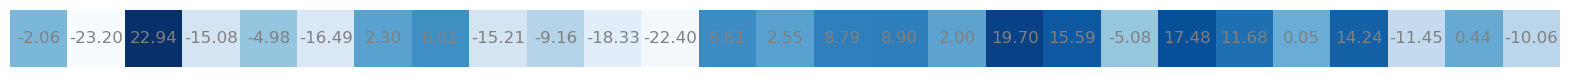

In [117]:
plot_heatmap(logits[0].data.view(1,-1), fig_size=(20,20))


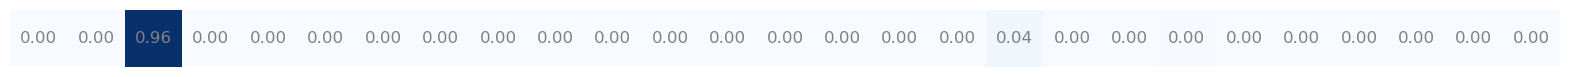

In [118]:
probs = F.softmax(logits, dim=1)
plot_heatmap(probs[0].data.view(1,-1), fig_size=(20,20))

## Let's have an open mind but not too open, you need some filter for stupidity!

logits = h @ W2 + b2

let's initialize `b2 to 0.0` and make **`W2 close to 0.0 but not exactly zero`**!!! See the difference, for now:

what's important is that, **`previously the gradients were in the direction to reduce the scale of the weights`**, now we did it manually for them, so training will be faster and more focused on low weights

In [21]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g)
b1 = torch.randn( HLAYER_SIZE, generator=g)
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g) * 0.01
b2 = torch.randn( NCLASS, generator=g) * 0.0
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

16062

In [22]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    h = torch.tanh(emb.view(BATCH_SIZE, -1)@W1 + b1 ) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    lossi.append(loss_mini.log10().item())
    stepi.append(i)

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        # break # intentionally added to stop to show the large loss

# print(f'loss_mini: {loss_mini.item()}')

iteration:       0 /  100000 | mini loss: 3.2958
iteration:   10000 /  100000 | mini loss: 2.1644
iteration:   20000 /  100000 | mini loss: 2.6223
iteration:   30000 /  100000 | mini loss: 2.3236
iteration:   40000 /  100000 | mini loss: 2.1224
iteration:   50000 /  100000 | mini loss: 2.1647
iteration:   60000 /  100000 | mini loss: 2.1931
iteration:   70000 /  100000 | mini loss: 2.4574
iteration:   80000 /  100000 | mini loss: 2.3013
iteration:   90000 /  100000 | mini loss: 2.5229


We get much **`lower loss both in the beginning & at the end with lower iteration`**!!

In [23]:
evaluate_loss('train')
evaluate_loss('dev')

train loss: 2.1572911739349365
dev loss: 2.229177474975586


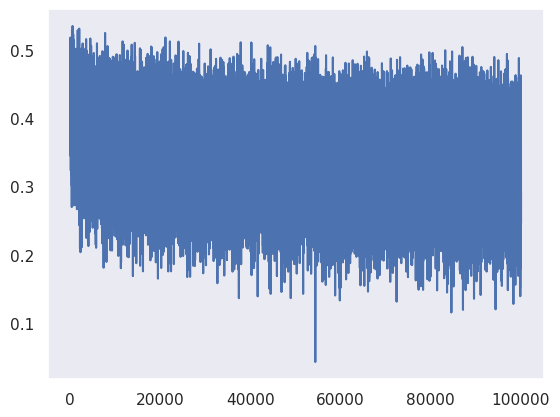

In [24]:
plt.plot(stepi, lossi)

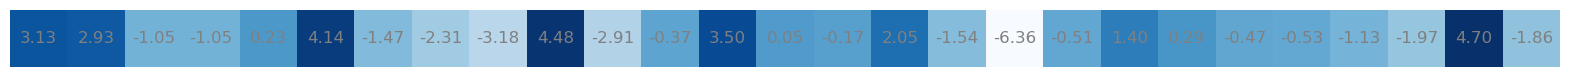

In [25]:
plot_heatmap(logits[0].data.view(1,-1), fig_size=(20,20))


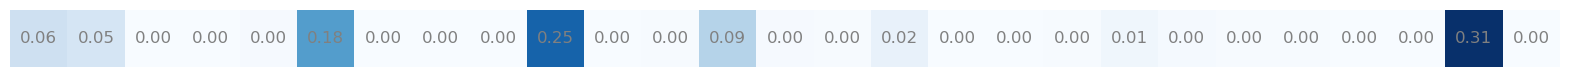

In [26]:
probs = F.softmax(logits, dim=1)
plot_heatmap(probs[0].data.view(1,-1), fig_size=(20,20))

## Hidden Layer Problems

tanh function is a squashing function, it maps the input between -inf & +inf to a value between -1 & 1 .


So **`if the input to hidden layer got extreme values`** (like we had in weights and logits), **`then the output will be always -1 or 1`** !!

**`The key general rule is that we don't want the output of both a single neuron and layer be independent of its inputs in the initialization, meaning when you have all equal output for all inputs`**

1- Independent output from input in a single Neuron, happens when you have extreme values in pre-activation (large std), you clamp the output to the saturation area like in tanh: -1 or +1
    
2-  you might have dependent output from a single point perspective but you still have independent layer output from the layer input, and happens when weight initialization is equal for all neurons, especially zero!!: **to test go to 01_3_micrograd last cell**
        
        the difference in gradient (d act/d w_i) between weights of a single Neuron only depends on the value of their respective input.

        If you initialize all weights in a single Neuron equally like all zeros, the (d out / d input) will be equal for all inputs. Of course what we want is (d out / d w) and it will be different depending on the input.
        
        but if you do this for another parallel Neurons in the same layer (which get the same inputs), then these 2 Neurons will be exactly the same and will have same gradient (d out / d w) as well, meaning we have duplicate neuron with same value update and information! it shows itself with same columns in the W ( actually by equal weights, all entries in the W will be the same, but it can also happen only ny same columns).

        If you do this for all neurons in a layer, then all neurons are duplicate and updating gradient will only change the scale of the gradient bc of the out_grad! and the direction of the gradient remain the same. For this reason "it affects only the scale of the gradient vector, not the direction". To avoid this duplicate problem, the initial weights to the network must be unequal.


In [31]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g)
b1 = torch.randn( HLAYER_SIZE, generator=g)
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g) * 0.01
b2 = torch.randn( NCLASS, generator=g) * 0.0
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

16062

In [32]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(BATCH_SIZE, -1)@W1 + b1
    h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    lossi.append(loss_mini.log10().item())
    stepi.append(i)

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        break # intentionally added to stop to show the large loss

# print(f'loss_mini: {loss_mini.item()}')

iteration:       0 /  100000 | mini loss: 3.3532


#### Plotting the Distribution of the layer output
we are **`maping the input distribtion by multiplication with a normal to another distribution` the we `pass it through a non-linearity function`**!!! isn't it beautiful !!

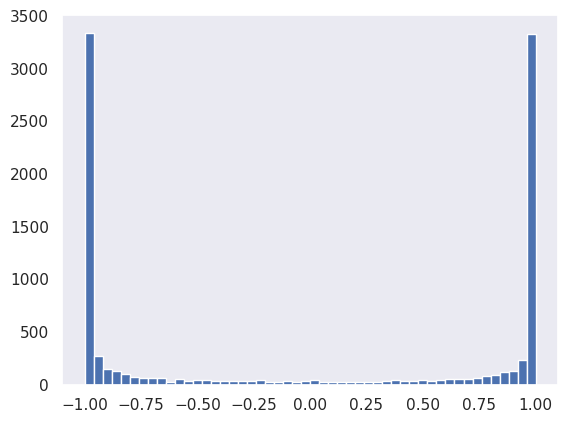

In [10]:
# most of the the values are -1 or +1
plt.hist(h.view(-1).tolist(), 50);

### let'see the pre-activation. the input to tanh 

hpreact = emb.view(BATCH_SIZE, -1)@W1 + b1

h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE

we can see that, of course **it's Gaussian but not normal!! bc embeddings, W1 & b1 are normal**, but after the operation **`the SD is extremely high, roughly around 6, while a size above 2 will map to -1 or +1`**.

What's the problem with that? look at the tanh!
**`You get zero gradient!!!`**:

1. **`no update on the weight itself!!! you get stuck there!!`**

2. **`you backprop zero gradient to weights behind you. no update for them as well, you block the gradient!!` f...!!**. In other words no matter how much the inputs change, they're not gonna impact the output of tanh and after that the loss!!

remember the backprop in tanh: **`grad = (1 - tanh**2) * out_grad`**
The gradient flowing back through tanh, can only ever decrease. bc it's always get multiplied by sth lower than 1.

**`The intuition`**:
tanh is like a valve, you need to open all valves (not equally) in the beginning and let the model learn by itself !!

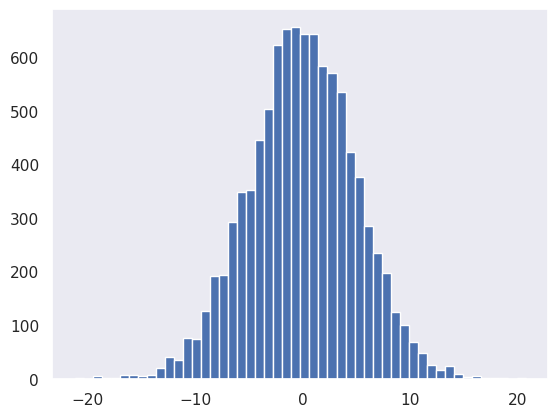

In [11]:
xs = np.arange(-3 ,3, 0.25)
ax1 = plt.subplot(211)
plt.hist(hpreact.view(-1).tolist(), 50);
plt.subplot(212, sharex=ax1)
plt.plot(xs, np.tanh(xs));

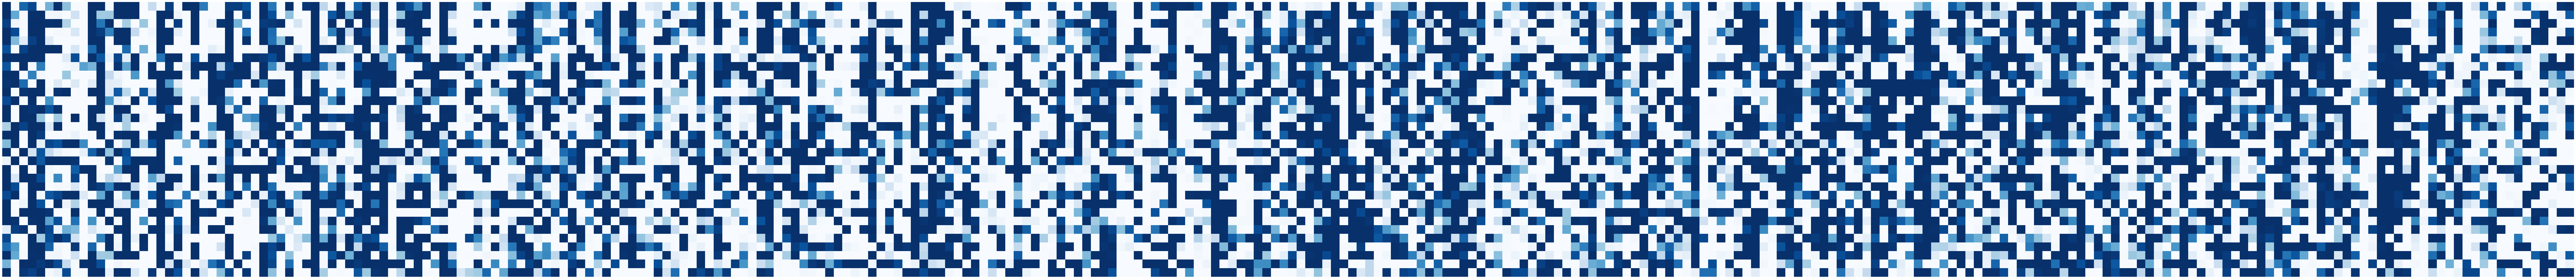

In [13]:
# expand the image and scrutinize it
plot_heatmap( h , text=False, fig_size=(150,350)) # BATCH_SIZE , HLAYER_SIZE

cols: Neurons HIDDEN LAYER

rows: samples in BATCH

if a Neuron blocks all gradients in the batch, it's literally dead !! it will never learn!!

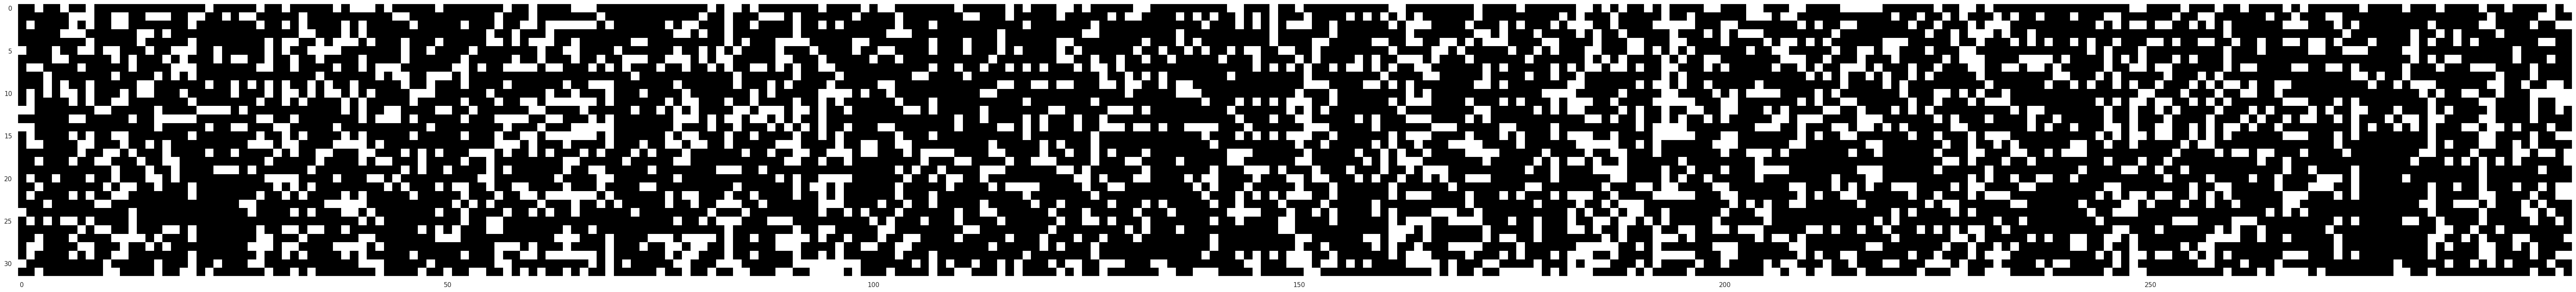

In [156]:
# let's create a boolean tensor to scrutinize the neurons
# open switches: white
# blocked switches: black
plt.figure(figsize=(80,40))
plt.imshow(h.abs() < 0.95, cmap='gray', interpolation='nearest')

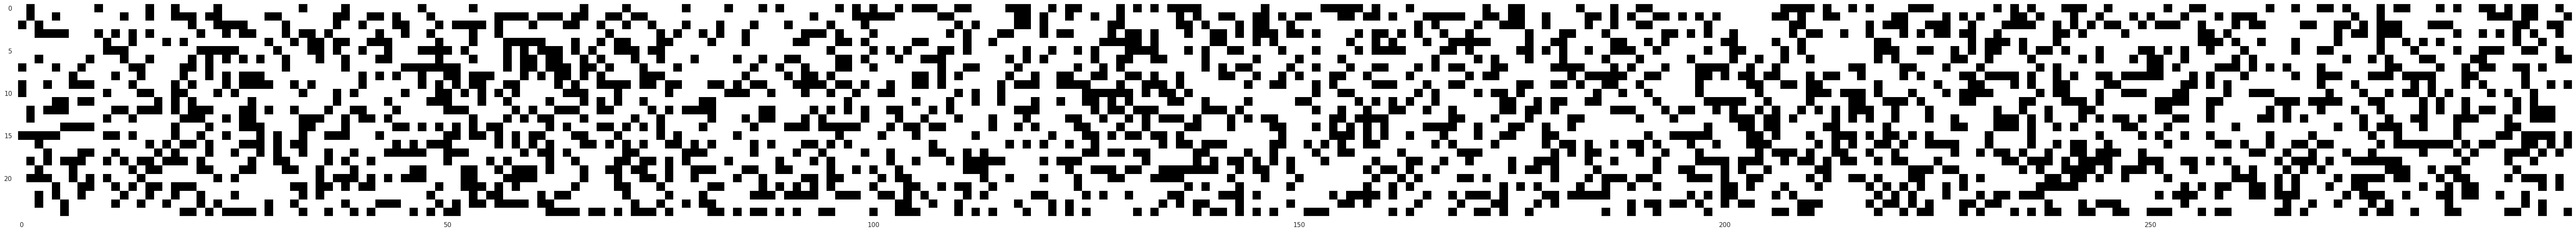

In [43]:
# plot_heatmap( W1.abs() > 0.7 , text=False, fig_size=(150,350)) # WINDOW_SIZE*EMB_DIM , HLAYER_SIZE
plt.figure(figsize=(80,40))
plt.imshow( W1.abs() < 0.95, cmap='gray', interpolation='nearest')

In [33]:
W1.min(), W1.max(), W1.mean(), W1.std()

(tensor(-3.6661, grad_fn=<MinBackward1>),
 tensor(3.7265, grad_fn=<MaxBackward1>),
 tensor(-0.0204, grad_fn=<MeanBackward0>),
 tensor(0.9981, grad_fn=<StdBackward0>))

### Let's try first 0.0 weights then a normal with std of 0.2:
1- as said before equal weights in all layers prevent you from learning and finding the correct gradient direction (weight dimensions) to reduce. especially in large networks. (not this one)


- set the bias to 0.0 or close to 0.0 (it might help optimization in practice)

- set W1 once to 0.0 (pre-activation and activation will be the same) and another time to 0.2, just to see what would happen!!

In [63]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g) * 0.0
b1 = torch.randn( HLAYER_SIZE, generator=g) * 0.01
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g) * 0.01
b2 = torch.randn( NCLASS, generator=g) * 0.01
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

16062

In [77]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(BATCH_SIZE, -1)@W1 + b1
    h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    lossi.append(loss_mini.log10().item())
    stepi.append(i)

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        break # intentionally added to stop to show the large loss

# print(f'loss_mini: {loss_mini.item()}')

iteration:       0 /  100000 | mini loss: 3.2620


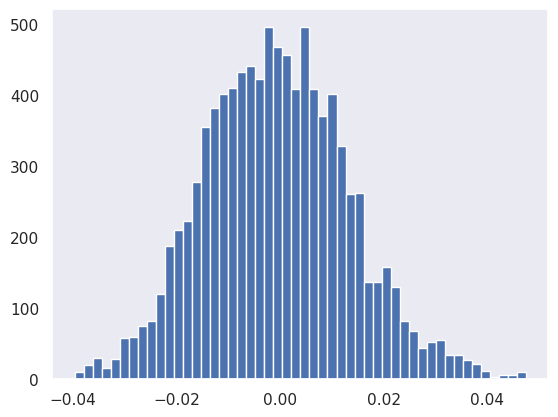

In [79]:
plt.hist(hpreact.view(-1).tolist(), 50);

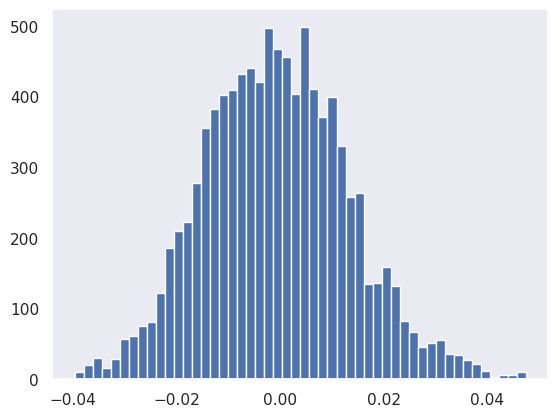

In [78]:
# most of the the values are -1 or +1
plt.hist(h.view(-1).tolist(), 50);

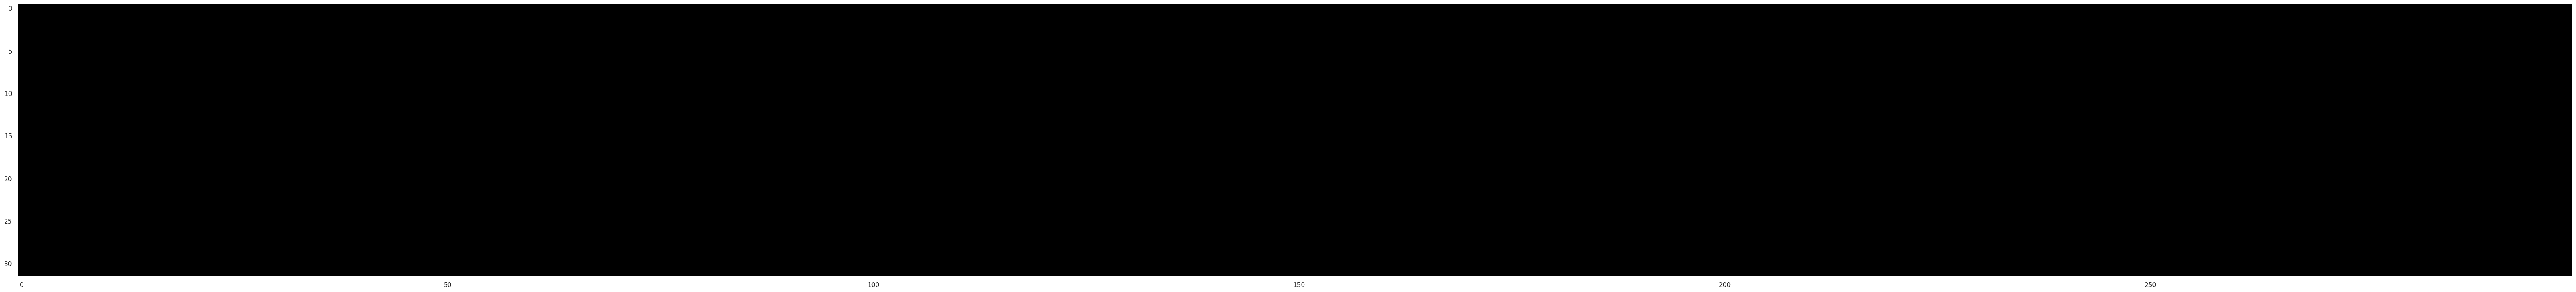

In [80]:
# let's create a boolean tensor to scrutinize the neurons
# open switches: white
# blocked switches: black
plt.figure(figsize=(80,40))
plt.imshow(h.abs() < 0.95, cmap='gray', interpolation='nearest') # BATCH_SIZE , HLAYER_SIZE
# There is a bug in imshow! it shows all white as all black!! 

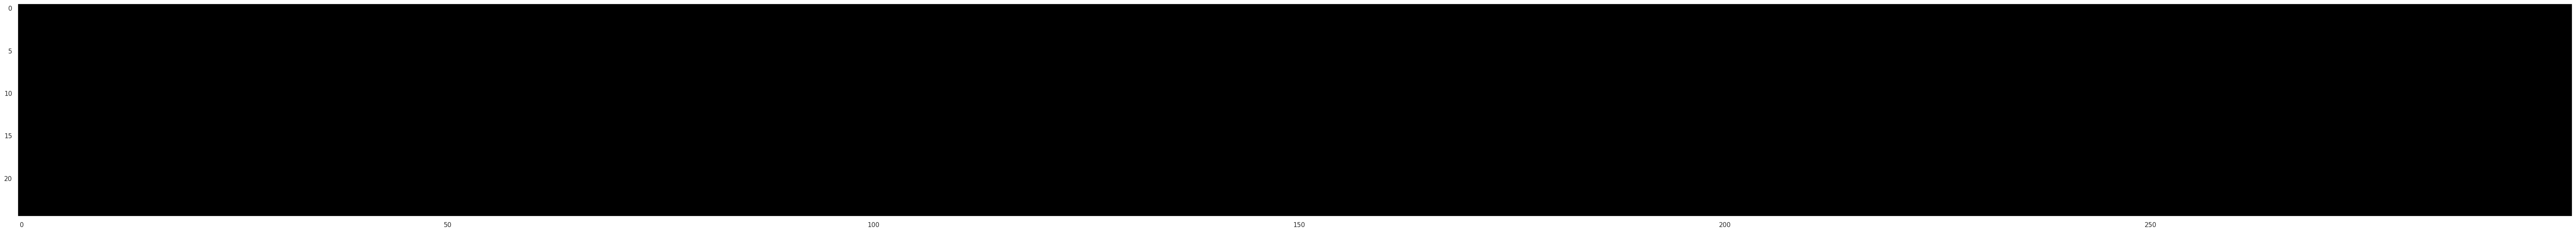

In [81]:
plt.figure(figsize=(80,40))
plt.imshow( W1.abs() < 0.5, cmap='gray', interpolation='nearest') # WINDOW_SIZE*EMB_DIM , HLAYER_SIZE
# There is a bug in imshow! it shows all white as all black!! 

In [51]:
W1.min(), W1.max(), W1.mean(), W1.std()

(tensor(-0.7332, grad_fn=<MinBackward1>),
 tensor(0.7454, grad_fn=<MaxBackward1>),
 tensor(-0.0041, grad_fn=<MeanBackward0>),
 tensor(0.1996, grad_fn=<StdBackward0>))

now we're working with a very small Network, this is just one layer MLP.

so because the network is so shallow the optimization problem is actually quite easy and very forgiving so even though our initialization was terrible the network still learned eventually.

this is not the case in general though once we actually start working with much deeper networks that have say 50 layers, things can get much more complicated and these problems Stack Up and so you can actually get into a place where the network is basically not training at all if your initialization is bad. The larger the model the fussier it get.

## What should be the initialization scale then?
1- First, we don't wanna set it zero bc then it means tanh is doing nothing, and the out.

2- below we can see a linear activation (no special function) and the mean & std of before & after Matrix multiplication of the 2 normal distro. we can see that the output is not normal, its std is higher than 1.

3- if X and W are two matrices whose **`entries are i.i.d. Gaussian`** random variables with **`mean 0 and variance 1, and Y = XW`** is their matrix multiplication, then the **`entries of Y will also be Gaussian`** random variables with **`mean 0 and variance root2(n)`**. Here, n is the number of columns in matrix X (indimension) . This result follows from the fact that the matrix multiplication Y = XW can be expressed as a linear combination of the columns of X (each dimension in the whole batch), where the coefficients of the linear combination are the entries of W. Since the columns of X are i.i.d. Gaussian random vectors, and the entries of W are i.i.d. Gaussian random variables, the linear combination of the columns of X with coefficients given by the entries of W will also be a Gaussian random vector.

3- For a linear activation, it turns out, mathematically, if you **`initialize the weights with a Gaussian with std = (1 / root2 of fan-in )`** you get a normal distro in the output of a linear neuron.

4- However researchers found that **`if you have non-linearity, and want the output of the activation function be normal as well`**. you also need to **`consider a gain (another coefficient) for std of the weights depending on your activation as a compensation. e.g. for tanh it's 5/3` (as a compensation for shrinking the value, compare tanh and linear function), for `ReLu it's root2 of fan-in` (bc you are basically blocking grading on negative values or half of distribution), `for sigmoid and CNN, it's 1`**

find all recommended gains here:

https://pytorch.org/docs/stable/nn.init.html

tensor(-0.0019) tensor(1.0070)
tensor(0.0004) tensor(3.1493)


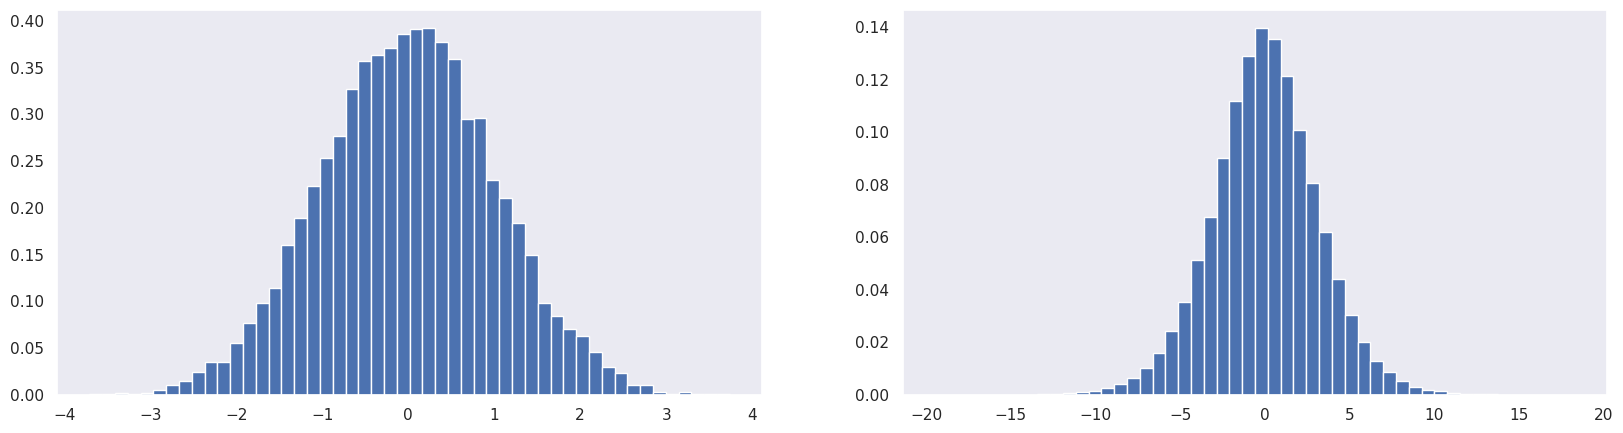

In [42]:
xtmp = torch.randn(1000,10) # batch_size, fanin
# initialize weights with a Gaussian with
# std = (1 / root2 of fan-in )
wtmp = torch.randn(10,200)# / 10**0.5 # fanin, layer_size
ytmp = xtmp @ wtmp
print( xtmp.mean(), xtmp.std() )
print( ytmp.mean(), ytmp.std() )
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(xtmp.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(ytmp.view(-1).tolist(), bins=50, density=True);

### The behavior of activation in Backward path

we wanna make sure that the gradients are also well behaved.

In the paper, "Diving deep into rectifiers" by Kaiming et al. they found that if we initialize the forward path properly the gradients are also well behaved.


## the weight initialization on whole batch
Let's try first 0.0 weights then a normal with the recommended std:

1- as said before equal weights in all layers prevent you from learning and finding the correct gradient direction (weight dimensions) to reduce. especially in large networks.

Here with 0.0 Ws you will see that the activations are almost binary!! either always 0 (full open) or always +-1 (closed), this is not good, it means neurons does not care about the input !!

but when you try the recommended gain and root2(fan-in) you see that neurons get on an off for some inputs, this good bc being on and off must depend on the input.



- set the bias to 0.0 or close to 0.0 (it might help optimization in practice)

- set W1 once to 0.0 (pre-activation and activation will be the same) and another time to 0.3, just to see what would happen!!


In [34]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g) * 5 / (3*(WINDOW_SIZE*EMB_DIM)**0.5)
b1 = torch.randn( HLAYER_SIZE, generator=g) * 0.01
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g) * 0.01 #/ (HLAYER_SIZE*NCLASS)**0.5
b2 = torch.randn( NCLASS, generator=g) * 0.01
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

16062

In [35]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(BATCH_SIZE, -1)@W1 + b1
    h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    lossi.append(loss_mini.log10().item())
    stepi.append(i)

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        # break # intentionally added to stop to show the large loss

# print(f'loss_mini: {loss_mini.item()}')

iteration:       0 /  100000 | mini loss: 3.2664
iteration:   10000 /  100000 | mini loss: 2.5194
iteration:   20000 /  100000 | mini loss: 2.1974
iteration:   30000 /  100000 | mini loss: 2.1651
iteration:   40000 /  100000 | mini loss: 2.3416
iteration:   50000 /  100000 | mini loss: 2.3360
iteration:   60000 /  100000 | mini loss: 2.6036
iteration:   70000 /  100000 | mini loss: 2.2633
iteration:   80000 /  100000 | mini loss: 1.8495
iteration:   90000 /  100000 | mini loss: 1.8123


In [36]:
evaluate_loss('train')
evaluate_loss('dev')

train loss: 2.0986831188201904
dev loss: 2.190480947494507


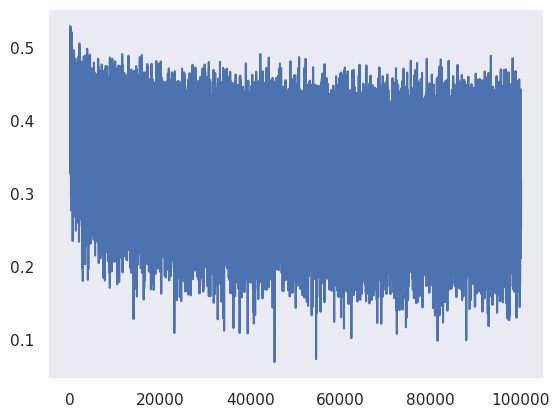

In [37]:
plt.plot(stepi, lossi)

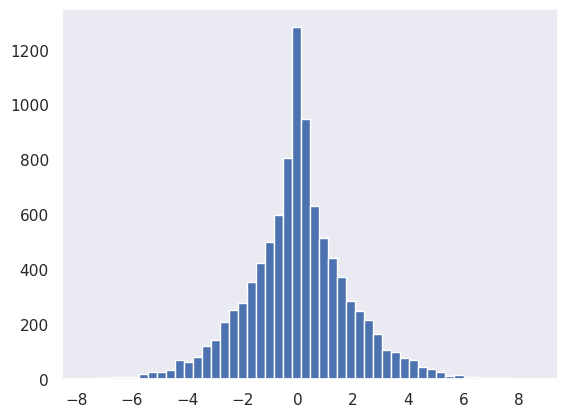

In [39]:
plt.hist(hpreact.view(-1).tolist(), 50);

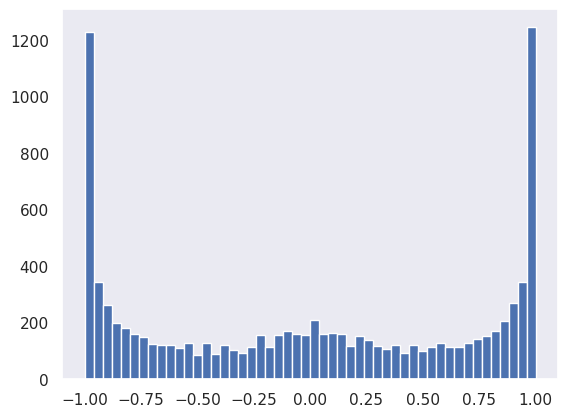

In [38]:
# most of the the values are -1 or +1
plt.hist(h.view(-1).tolist(), 50);

**` the above looks more like a Laplacian than a Gaussian!!`**

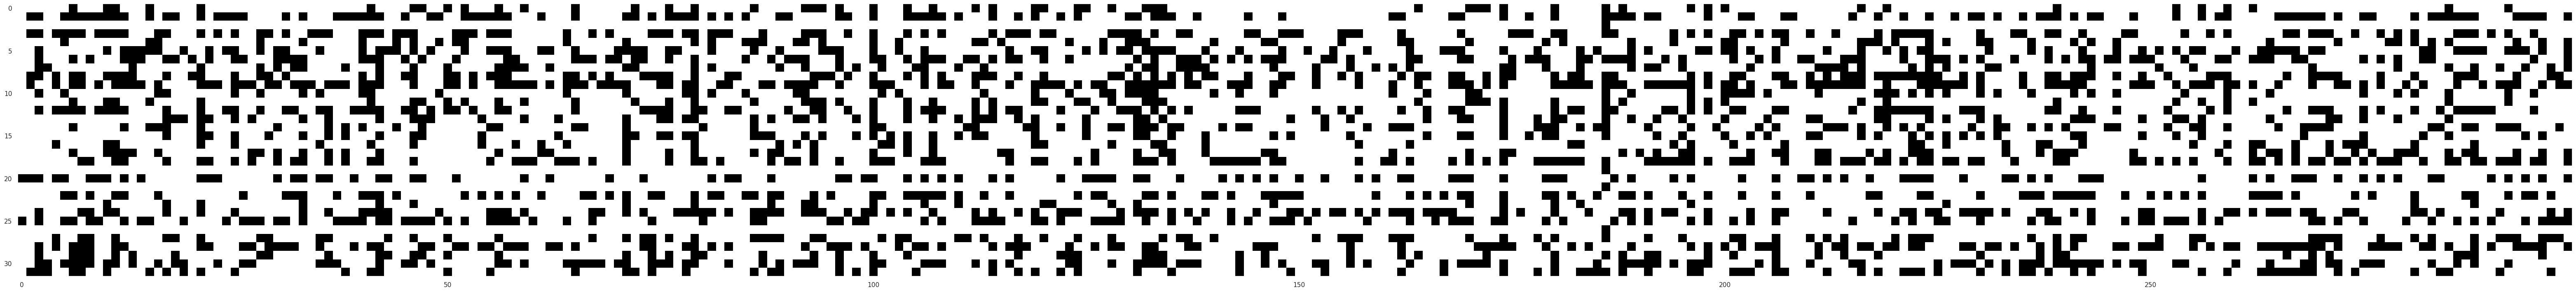

In [40]:
# let's create a boolean tensor to scrutinize the neurons
# open switches: white
# blocked switches: black
plt.figure(figsize=(80,40))
plt.imshow(h.abs() < 0.95, cmap='gray', interpolation='nearest')

## Modern innovation obviate the need to fully observe these initializations

in the next files:

1. Residual Connections

2. Batch Normalization, layer normalization, froup normalization

3. Better optimizers: RMS prop, Adam

## What if we use a uniform distro instead of Normal!
**`In PyTorch the default initialization for a Linear activation is Uniform between( -root2 fan-in , root2 fan-in ) and this is good initialization only for a linear activation`. in case of non-linear activations, we also need a gain**!.

In most cases, use Gaussian for non-linear activations.
try it yourself, and learn sth new in the following:

In [17]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.rand( NCLASS, EMB_DIM, generator=g) * 2.0 - 1.0 # to be between U(-1 , 1)
W1 = torch.rand( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g) * 2.0 - 1.0 # to be between U(-1 , 1)
b1 = torch.rand( HLAYER_SIZE, generator=g) * 0.02 - 0.01
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g) * 0.01
b2 = torch.randn( NCLASS, generator=g) * 0.01
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

16062

In [18]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(BATCH_SIZE, -1)@W1 + b1
    h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    lossi.append(loss_mini.log10().item())
    stepi.append(i)

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        break # intentionally added to stop to show the large loss

# print(f'loss_mini: {loss_mini.item()}')

iteration:       0 /  100000 | mini loss: 3.3158


In [19]:
W1.min(), W1.max(), W1.mean(), W1.std()

(tensor(-0.9997, grad_fn=<MinBackward1>),
 tensor(0.9999, grad_fn=<MaxBackward1>),
 tensor(0.0025, grad_fn=<MeanBackward0>),
 tensor(0.5770, grad_fn=<StdBackward0>))

In [34]:
evaluate_loss('train')
evaluate_loss('dev')

train loss: 2.0950722694396973
dev loss: 2.1660752296447754


Well, we get even better results, so why bother ourselves with Gaussian !!?

Look at below!!! What!!!

Why do they look like Gaussian in the pre-activation !!

I asked ChatGPT:

1- if the two matrices you generated are **`square matrices of the same size, and their elements are i.i.d. uniform random variables`**, then the distribution of the elements in their matrix multiplication will **`tend to be Gaussian`**, according to the **`circular law`**.
    
**However**, if the matrices are not square or their elements are not i.i.d. uniform random variables, then the **distribution of the elements in their matrix multiplication will be more difficult to determine**.

So we'd rather to use Gaussian to make sure things stay more in control !!

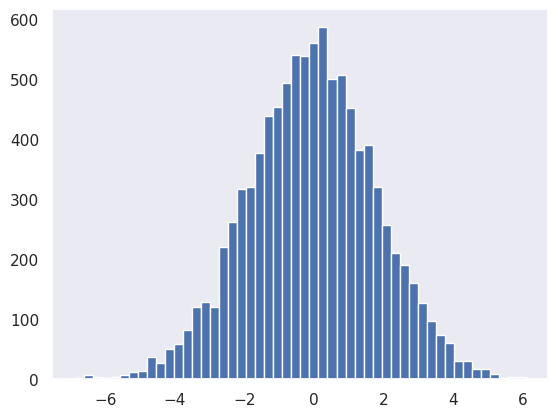

In [20]:
plt.hist(hpreact.view(-1).tolist(), 50);

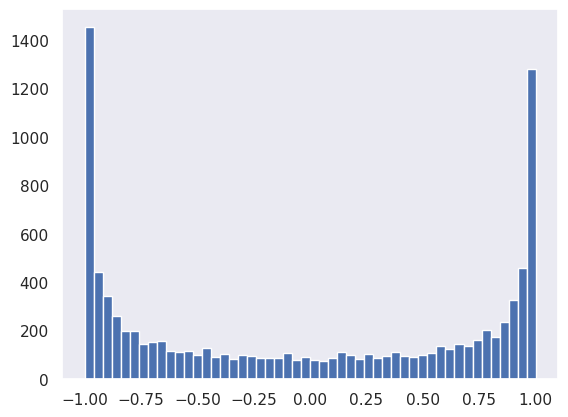

In [21]:
# most of the the values are -1 or +1
plt.hist(h.view(-1).tolist(), 50);

tensor(0.4975) tensor(0.2919)
tensor(2.4791) tensor(0.6805)


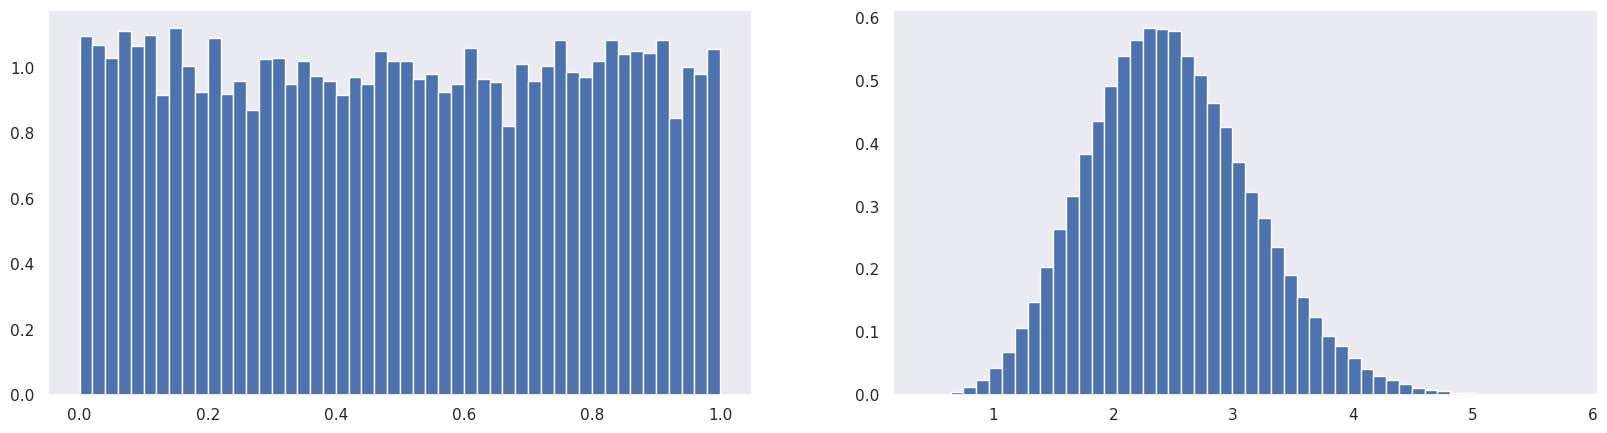

In [5]:
xtmp = torch.rand(1000,10) #* 10 # batch_size, fanin
# initialize weights with a Gaussian with
# std = (1 / root2 of fan-in )
wtmp = torch.rand(10,200) #* 10 # fanin, layer_size
ytmp = xtmp @ wtmp
print( xtmp.mean(), xtmp.std() )
print( ytmp.mean(), ytmp.std() )
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(xtmp.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(ytmp.view(-1).tolist(), bins=50, density=True);

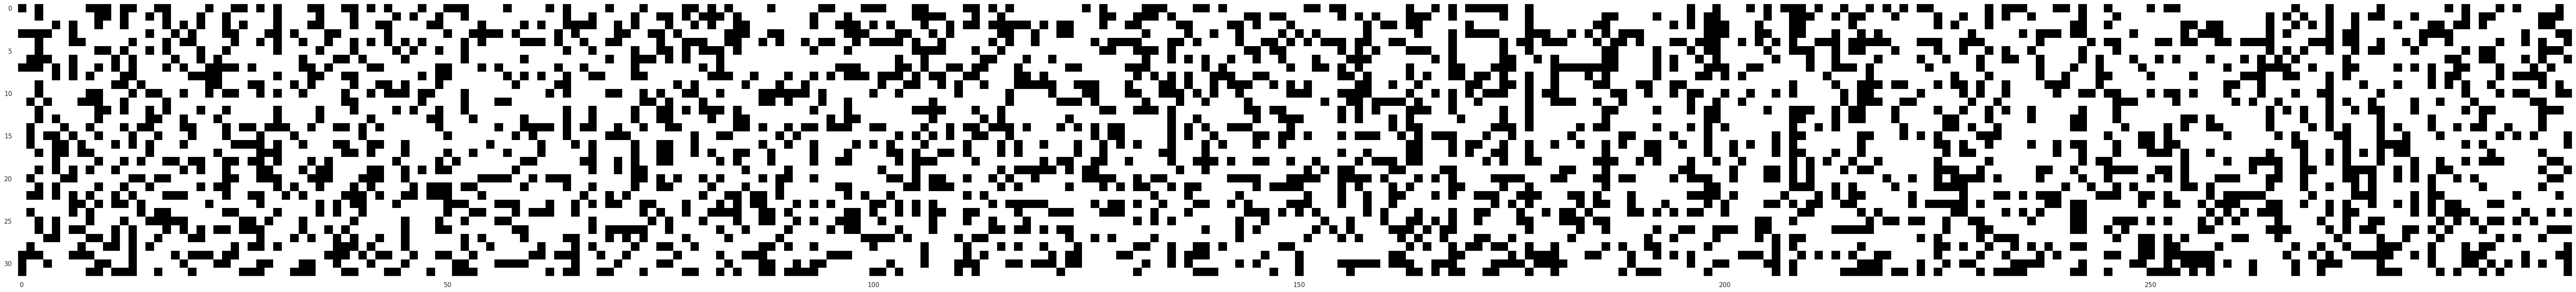

In [22]:
# let's create a boolean tensor to scrutinize the neurons
# open switches: white
# blocked switches: black
plt.figure(figsize=(80,40))
plt.imshow(h.abs() < 0.95, cmap='gray', interpolation='nearest') # BATCH_SIZE , HLAYER_SIZE
# There is a bug in imshow! it shows all white as all black!! 

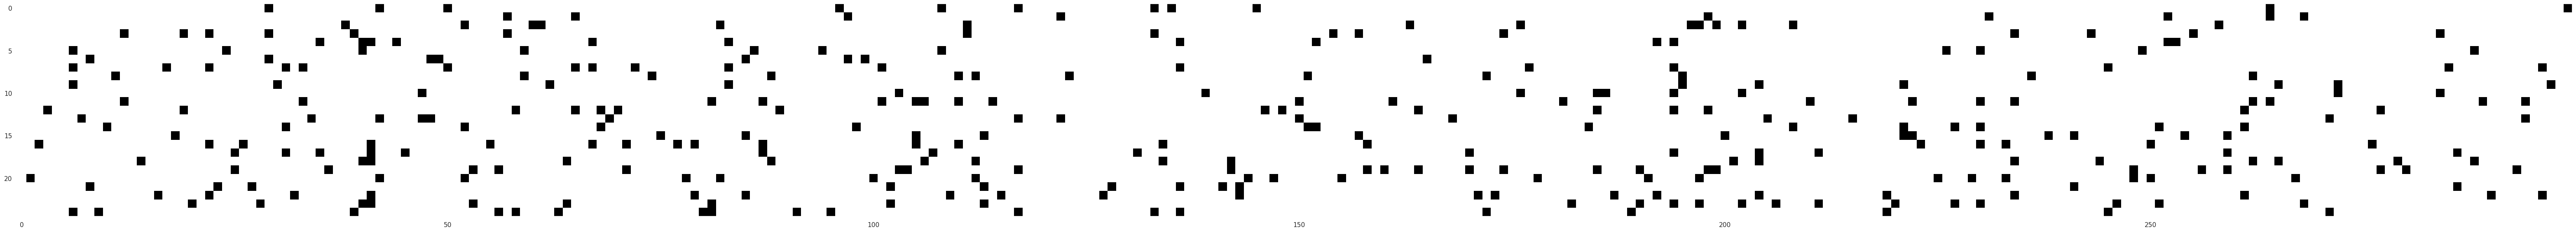

In [23]:
plt.figure(figsize=(80,40))
plt.imshow( W1.abs() < 0.95, cmap='gray', interpolation='nearest') # WINDOW_SIZE*EMB_DIM , HLAYER_SIZE
# There is a bug in imshow! it shows all white as all black!! 

In [32]:
W1.min(), W1.max(), W1.mean(), W1.std()

(tensor(-0.9998, grad_fn=<MinBackward1>),
 tensor(0.9997, grad_fn=<MaxBackward1>),
 tensor(0.0025, grad_fn=<MeanBackward0>),
 tensor(0.5770, grad_fn=<StdBackward0>))

## Hyperparameter Tuning

1- if the training loss is roughly equal (.2f) to the dev loss, it means the model is under-fitted. it's not big enough to just purely memorizes the data. so we can scale the model and increase the number of parameters, meaning the size of hidden layer and embeddings.

2- On the other side, if your overfitting to traing data set, it means the model is to big and over-parameterized. so you have 2 options find a larger dataset, or lower the number of parameters.

Also tune the lr here! first continue with 0.1 till you don't improvement in the total train loss then go with 0.01 and lower. see the dev_loss as well.

In [15]:
EMB_DIM = 3
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g)
b1 = torch.randn( HLAYER_SIZE, generator=g)
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g)
b2 = torch.randn( NCLASS, generator=g)
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

10881

### increasing the size of Embeddings
Also tune the lr here! first continue with 0.1 till you don't improvement in the total train loss then go with 0.01 and lower. see the dev_loss as well.

In [50]:
lri = []
lr_expo = torch.linspace(start=-3, end=0, steps=1000)
exponential_lr = 10**lr_expo

BATCH_SIZE = 32
loglossi = []
stepi = []

NSTEPS = 10000

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    h = torch.tanh(emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)@W1 + b1 ) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    # counts = logits.exp() # * equivalent to counts [b, NCLASS]
    # probs = counts / counts.sum(dim=1 , keepdim=True) #[b, NCLASS]
     
    # loss = -probs[torch.arange(BATCH_SIZE), ys].log().mean() + l2coef*(W**2).mean()

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    
    loglossi.append(loss_mini.log10().item())
    stepi.append(i)

    lr = exponential_lr[i]
    lri.append(lr_expo[i]) # store the exponent

    loss_mini.backward()

    # update &
    # set the weight grads to None, PyTorch interpret it as 0
    # but None is more efficient
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # print(f'iteration: {i} | loss: {loss.item()}')

print(f'loss_mini: {loss_mini.item()}')

loss_mini: 1.905316710472107


In [ ]:
evaluate_loss('train')
evaluate_loss('dev')

In [ ]:
plt.plot(lri, loglossi)

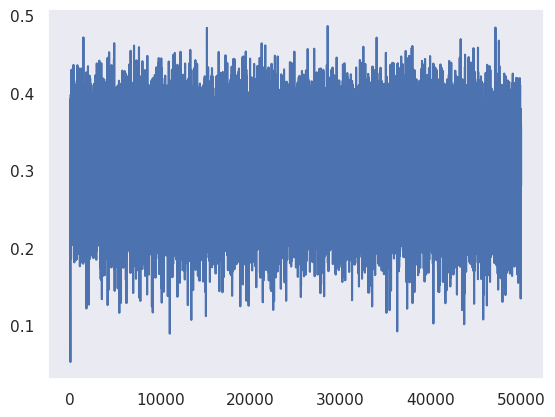

In [51]:
plt.plot(stepi, loglossi)

## Let's Generate some samples like Bigram

In [173]:

g = torch.Generator().manual_seed(2147483647)
for _ in range(10):
    idx_y = 0
    name = ''
    context_window = [0]*WINDOW_SIZE
    
    while True:
        # Forward path
        emb = emb_lkt[torch.tensor([context_window])] # BATCH_SIZE=1, WINDOW_SIZE, emb_dim
        h = torch.tanh(emb.view(-1, WINDOW_SIZE*EMB_DIM)@W1 + b1 ) # BATCH_SIZE, hlayer_size
        logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
        probs = F.softmax(logits, dim=1)
        
        idx_y = torch.multinomial(probs.detach(), num_samples=1, replacement=True, generator=g).item()
        # shift_to_left context window and append the idx_y
        context_window = context_window[1:] + [idx_y]
        if idx_y == 0:
            break
        ch = i_to_s[idx_y]
        # print(ch)
        name += ch
    print(name)

mena
tyffi
jonniya
sammell
higed
manuelynn
hasedeneala
eluped
jermane
mahaylan
